# Problem Set 3

### CSCI 5352

### Ben Braun

In [511]:

import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd


In [512]:
def read_edgelist(file,delimiter=','):
	# make an adjacency list
	adjacency_list = {}
	current_node = 1
	current_adjacencies = []
	with open(file) as f:
		while True:
			# split the line by whatever delimiter is used in the file
			edge = f.readline().split(delimiter)
			# if we've reached the end of the file, we break out of the loop
			if not edge:
				adjacency_list[current_node] = current_adjacencies
				break
			# the files are sorted by the second node, so we can build up each node's list before appending it to the full adjacency list
			# this helps avoid excessive read/writes to the large data structure
			if int(edge[1]) == current_node:
				current_adjacencies.append(int(edge[0]))
			else:
				# now we're at the next node, so we append the completed adjacency list for the previous node to the full adjacency list
				adjacency_list[current_node] = current_adjacencies
				# then we reset the current node and adjacency list and start building up the next node's list
				current_node = int(edge[1])
				current_adjacencies = [int(edge[0])]
	
	return adjacency_list

## Problem 1

In [513]:
# read board of directors network

import networkx as nx
from networkx.readwrite.graphml import read_graphml

file = 'net1m_2011-08-01.xml'

graphml_str = open(file).read()
graphml_str = graphml_str.replace('attr.type="vector_float"', 'attr.type="string"')
graphml_str = graphml_str.replace('attr.type="short"', 'attr.type="string"')
graphml_str = graphml_str.replace('attr.type="vector_string"', 'attr.type="string"')


# Read the GraphML string as a NetworkX graph
boards_graph = nx.parse_graphml(graphml_str, node_type=str, edge_key_type=str)

# Extract metadata and store in a dictionary
boards_metadata = {}

# Extract nodes and their metadata
for node in boards_graph.nodes(data=True):
	node_id, attributes = node
	# parse gender attribute
	attributes['gender'] = {'1':'Male','2':'Female'}[attributes['gender']]
	
	boards_metadata[node_id] = attributes


In [514]:
# read Malaria network

malaria_graph = nx.read_edgelist('HVR_5.txt',delimiter=',')

malaria_metadata = {}
with open('metadata_CysPoLV.txt') as f:
	# each line contains a single integer
	for i, line in enumerate(f.readlines()):
		malaria_metadata[str(i+1)] = line.strip()

len(malaria_metadata)


307

In [569]:
# Local smoothing heuristic (defaulting to baseline, breaking ties randomly)
import numpy as np
import random
from collections import Counter
from tqdm import tqdm


def local_smoothing(graph,metadata,alpha,baseline_only=False):

	# randomly sample nodes (alpha*N)
	known_nodes = np.random.choice(graph.nodes(), int(alpha * len(graph.nodes())), replace=False)

	meta_predictions = {}
	for node,data in metadata.items():
		meta_predictions[node] = {
			'true_value':data,
			'known':node in known_nodes,
			'predicted':None,
		}
	
	# predict missing labels
	for node in set(graph.nodes()) - set(known_nodes):
		# get the true values of known neighbors
		neighbor_values = [meta_predictions[n]['true_value'] for n in graph.neighbors(node) if n in known_nodes]

		# categorical prediction is based on mode
		if len(neighbor_values) > 0 and not baseline_only:
			meta_predictions[node]['predicted'] = Counter(neighbor_values).most_common()[0][0]
		else:
			# fall back to baseline (get a uniformly random sample from the known nodes)
			meta_predictions[node]['predicted'] = random.choice([meta_predictions[n]['true_value'] for n in known_nodes])

	# measure accuracy (# correct predictions / # inputs)
	correct_predictions = sum(pred['true_value'] == pred['predicted'] for pred in meta_predictions.values() if not pred['known'])
	inputs = len(graph.nodes()) - len(known_nodes)
	accuracy = correct_predictions / inputs

	return accuracy


In [570]:
malaria_obs = pd.DataFrame(columns=['alpha','accuracy'])

delta_alpha = 0.02
reps = 100

for alpha in tqdm(np.arange(1/len(malaria_graph.nodes()),1,delta_alpha)):
	for rep in range(reps):
		acc = local_smoothing(malaria_graph,malaria_metadata,alpha)
		malaria_obs.loc[len(malaria_obs)] = [alpha,acc]

malaria_obs

100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


,alpha,accuracy
0,0.003356,0.582492
1,0.003356,0.582492
2,0.003356,0.582492
3,0.003356,0.067340
4,0.003356,0.582492
...,...,...
4995,0.983356,0.800000
4996,0.983356,0.600000
4997,0.983356,0.600000
4998,0.983356,0.800000


In [162]:

boards_metadata_simple = {}
for node, metadata in boards_metadata.items():
	boards_metadata_simple[node] = metadata['gender']


board_obs = pd.DataFrame(columns=['alpha','accuracy'])

delta_alpha = 0.02
reps = 100

# for alpha in np.arange(1/len(boards_graph.nodes()),1,delta_alpha):
# tqdm
for alpha in tqdm(np.arange(1/len(boards_graph.nodes()),1,delta_alpha)):
	for rep in range(reps):
		acc = local_smoothing(boards_graph,boards_metadata_simple,alpha)
		board_obs.loc[len(board_obs)] = [alpha,acc]


board_obs

100%|██████████| 50/50 [08:02<00:00,  9.65s/it]


,alpha,accuracy
0,0.000704,0.360563
1,0.000704,0.638732
2,0.000704,0.360563
3,0.000704,0.360563
4,0.000704,0.638732
...,...,...
4995,0.980704,0.214286
4996,0.980704,0.214286
4997,0.980704,0.214286
4998,0.980704,0.321429


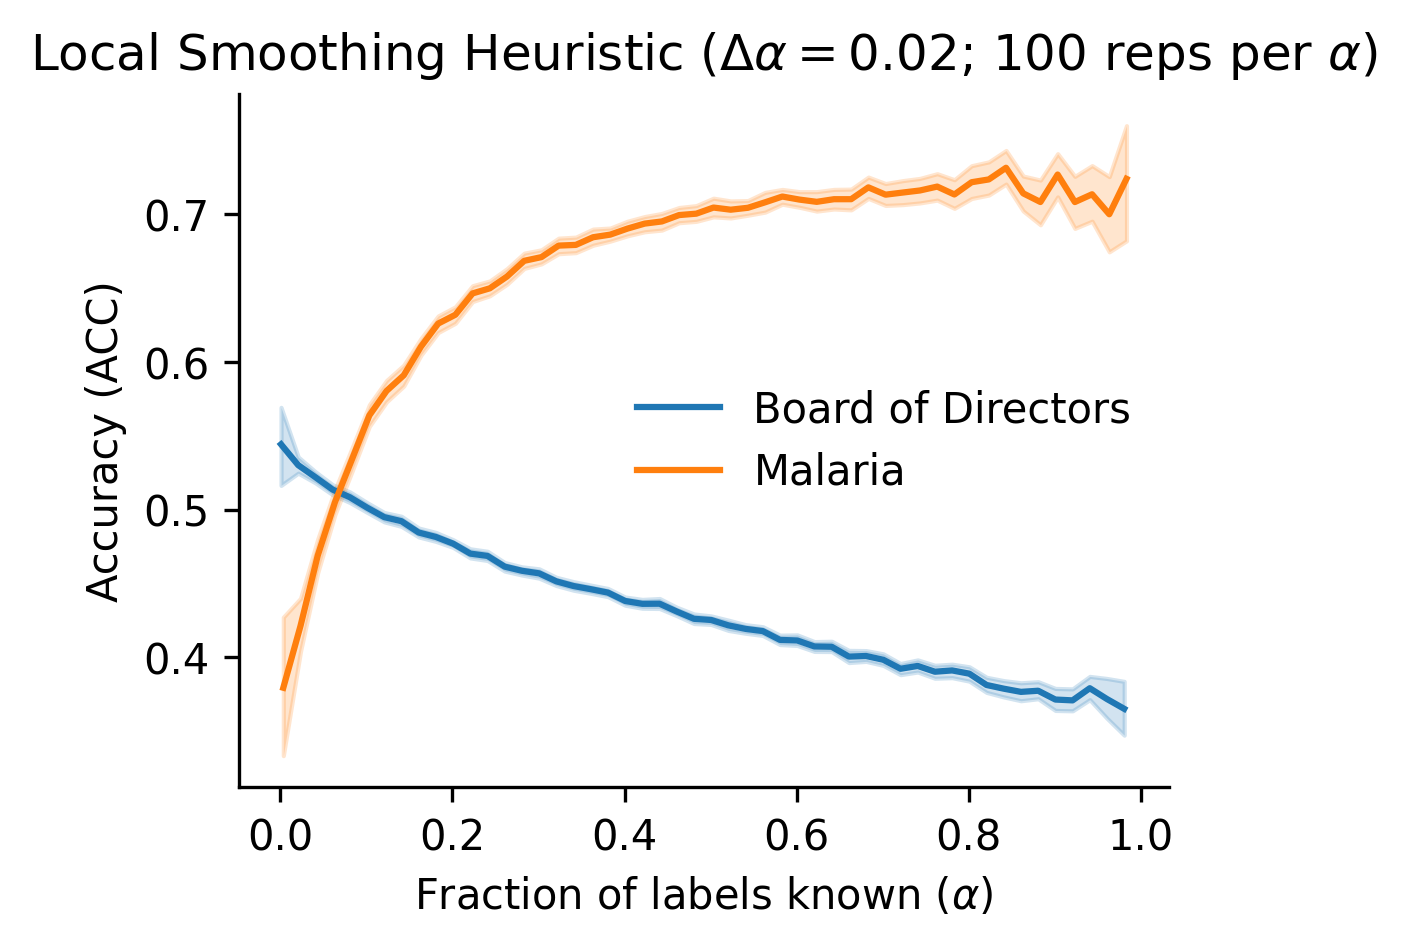

In [572]:
# plot accuracy vs alpha
fig, ax = plt.subplots(figsize=(4,3),dpi=300)

sns.lineplot(data=board_obs,x='alpha',y='accuracy',label='Board of Directors')
sns.lineplot(data=malaria_obs,x='alpha',y='accuracy',label='Malaria')
ax.set_ylabel('Accuracy (ACC)')
ax.set_xlabel('Fraction of labels known ($\\alpha$)')
plt.legend(frameon=False)

ax.set_title('Local Smoothing Heuristic ($\\Delta\\alpha=0.02$; 100 reps per $\\alpha$)')

sns.despine()
plt.show()

The accuracy curves for these two networks are very different. The baord of directors network starts off at an accuracy barely better than chance (0.5) and steadily declines as more neighbor labels are added, but it never gets very accurate, reaching only ~0.38 by the time all neighbor labels are added. Since we're predicting a simple binary attribute here, we would expect this performance to be much better if the social network exhibited assortative mixing. Since the accuracy decreases, I would guess that the network is actually disassortative, with edges between different genders being more common than edges between the same genders. It could also be an effect due to the difference in frequency between males and females. There are 908 males but only 513 females, so the predictions will generally be biased toward male, and this effect will scale linearly with the number of neighbors. At high values of $\alpha$, the prediction accuracy is still roughly proportional to the class imbalance.

In the Malaria network, there is a pattern of initial increase in accuracy as information is added, only for it to eventually decrease for $\alpha>0.7$. The last prediction when all neighbors are known has worse accuracy as the first prediction when no neighbors are known. I believe this is partially a consequence of the decreasing input size. At high $\alpha$'s, there are relatively few inputs for the prediction and incorrect predictions have a larger impact on the accuracy. The effect could also be due to misclassification of minority classes, which become less likely to be predicted correctly as they become surrounded by dissimilar neighbors.


The probability of guessing the true value of the missing node is proportional to the number of nodes in the known distribution with that value.

If we have $k$ unique labels and label $x_i$ appears $n_i$ times in the network, then the probability of guessing $x_i$ is $p_i = \frac{n_i}{N}$, where $N$ is the total number of nodes in the network. The probability that the guess is correct is also $p_i = \frac{n_i}{N}$, so we multiply those events to find the probability of guessing a missing label correctly. The expected accuracy is the sum of these probabilities over all labels:

$$
\mathbb{E}[\text{ACC}] = \sum_{i=1}^k p_i^2 = \sum_{i=1}^k \frac{n_i^2}{N^2} = \frac{1}{N^2} \sum_{i=1}^k n_i^2
$$

In [198]:
def expected_baseline_accuracy(metadata):

	# get the empirical distribution of the labels
	label_distribution = Counter(metadata.values())

	# calculate the expected accuracy of the baseline predictor
	expected_accuracy = sum([v**2 for v in label_distribution.values()]) / sum(label_distribution.values())**2

	return expected_accuracy

In [200]:
expected_baseline_accuracy(boards_metadata_simple)

0.5386345661562933

In [199]:
expected_baseline_accuracy(malaria_metadata)

0.36977580663985826

The baseline expected accuracy for the board of directors network is ~0.54, and for the malaria network it is ~0.37. These are roughly equal to the accuracy of the local smoothing heuristic when $\alpha$ is small. As $\alpha$ increases, the accuracy begins to deviate from this baseline since more nodes have neighbors with known labels.

### Part B

In [234]:
# Run local smoothing with constant alpha, but varying the randomness beta (fraction of edges randomized)

alpha = 0.8

metadata = boards_metadata_simple

m = len(graph.edges())

board_beta_obs = pd.DataFrame(columns=['beta','accuracy'])
step_size = 100

for i in range(10):
	graph = boards_graph.copy()
	for r in tqdm(np.arange(0,2*m+1,step_size)):
		# perform a double-edge swap
		nx.double_edge_swap(graph,nswap=step_size,max_tries=1000)

		# sample the local smoothing
		acc = local_smoothing(graph,metadata,alpha,mode='categorical',baseline_only=False)
		board_beta_obs.loc[len(board_beta_obs)] = [r/(2*m),acc]


board_beta_obs

  0%|          | 0/54 [00:00<?, ?it/s]

100%|██████████| 54/54 [00:03<00:00, 14.19it/s]


,beta,accuracy
0,0.000000,0.428070
1,0.018629,0.382456
2,0.037258,0.385965
3,0.055887,0.375439
4,0.074516,0.431579
...,...,...
535,0.912817,0.526316
536,0.931446,0.533333
537,0.950075,0.543860
538,0.968703,0.550877


In [266]:
alpha = 0.8

metadata = malaria_metadata

m = len(graph.edges())

malaria_beta_obs = pd.DataFrame(columns=['beta','accuracy'])
step_size = 100

for i in range(10):
	graph = malaria_graph.copy()
	for r in tqdm(np.arange(0,2*m+1,step_size)):
		# perform a double-edge swap
		nx.double_edge_swap(graph,nswap=step_size,max_tries=step_size*100)

		# sample the local smoothing
		acc = local_smoothing(graph,metadata,alpha,mode='categorical',baseline_only=False)
		malaria_beta_obs.loc[len(malaria_beta_obs)] = [r/(2*m),acc]


malaria_beta_obs

100%|██████████| 54/54 [00:00<00:00, 92.08it/s]


,beta,accuracy
0,0.000000,0.594203
1,0.018629,0.579710
2,0.037258,0.594203
3,0.055887,0.637681
4,0.074516,0.594203
...,...,...
535,0.912817,0.478261
536,0.931446,0.521739
537,0.950075,0.550725
538,0.968703,0.507246


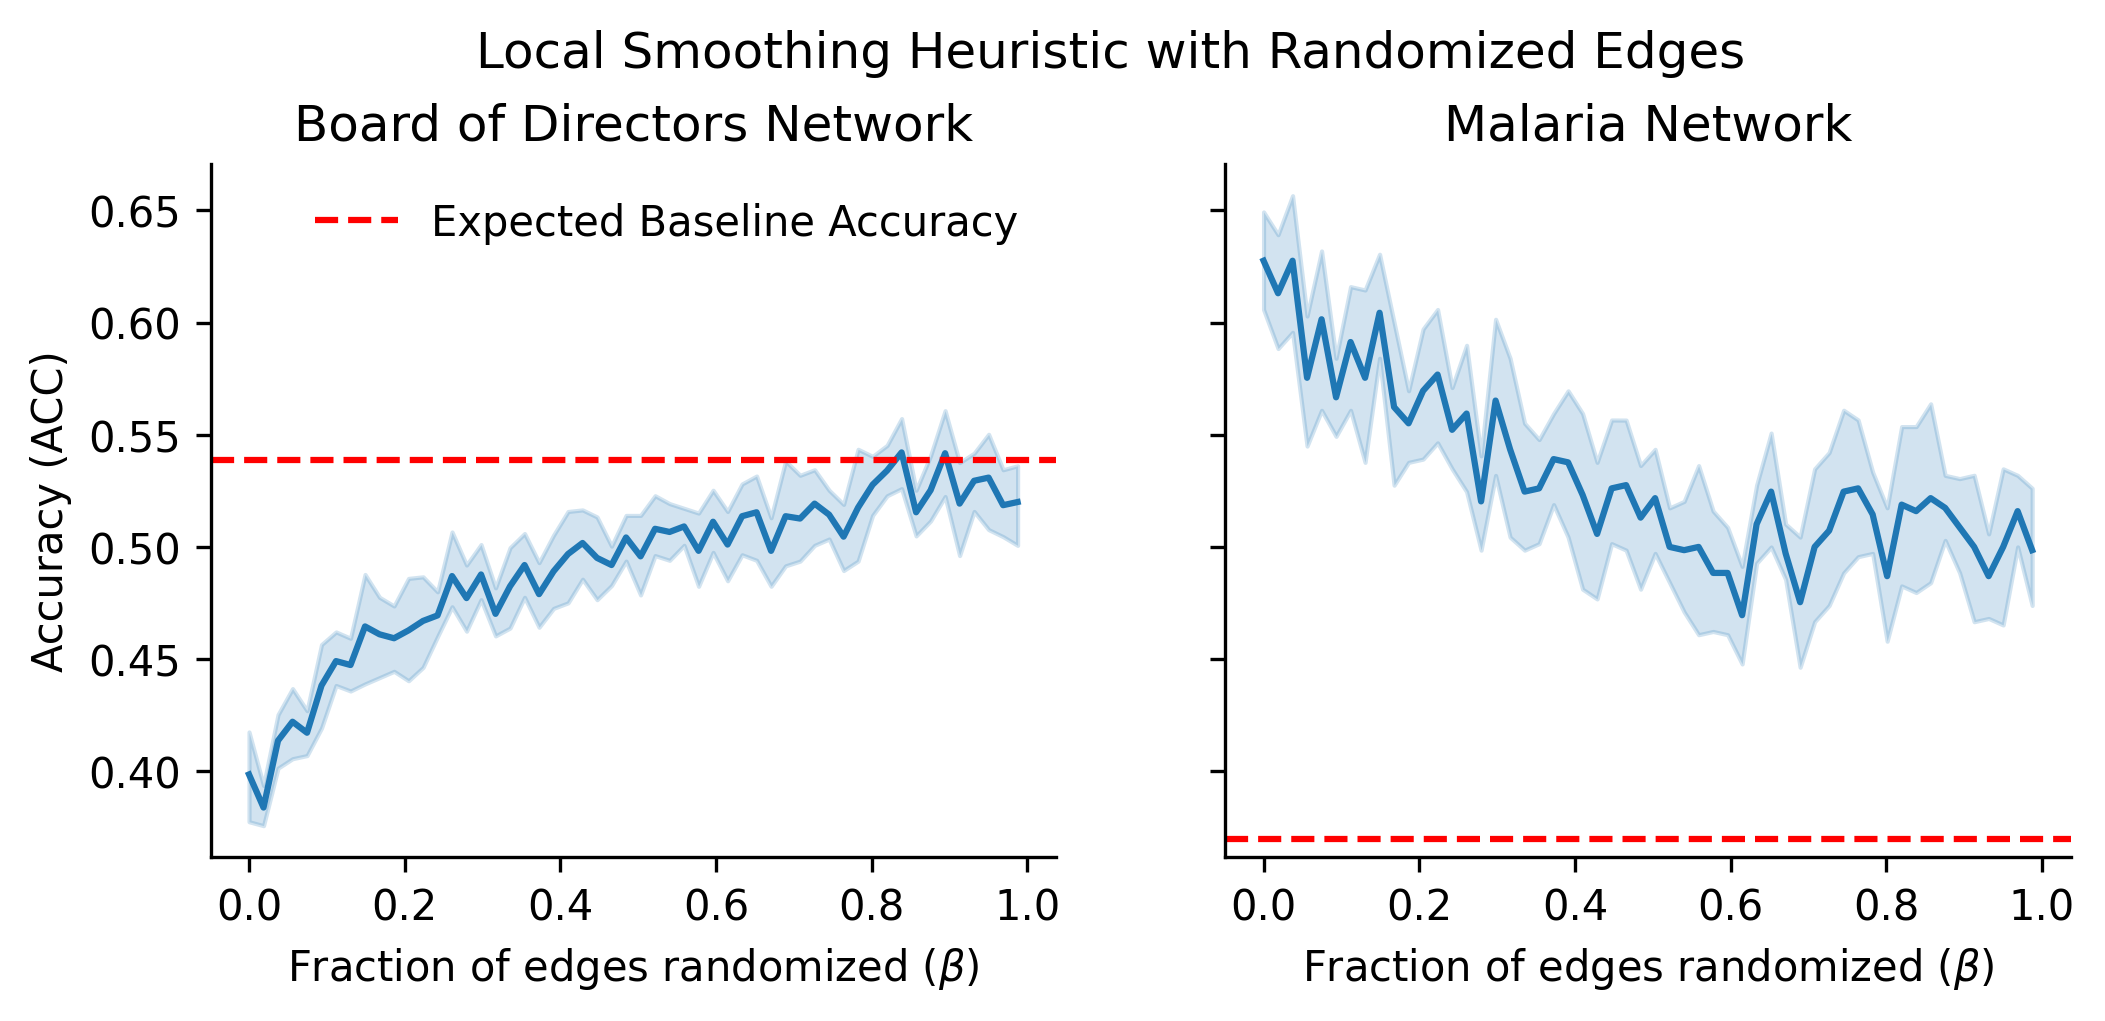

In [ ]:
# plot accuracy vs alpha
fig, ax = plt.subplots(1,2,figsize=(8,3),dpi=300,sharey=True)

sns.lineplot(data=board_beta_obs,x='beta',y='accuracy',ax=ax[0])
ax[0].set_title('Board of Directors Network')
ax[0].set_xlabel('$\\beta$')
ax[0].set_ylabel('Accuracy (ACC)')
ax[0].set_xlabel('Fraction of edges randomized ($\\beta$)')
ax[0].axhline(expected_baseline_accuracy(boards_metadata_simple),color='red',linestyle='--')

sns.lineplot(data=malaria_beta_obs,x='beta',y='accuracy',ax=ax[1])
ax[1].set_title('Malaria Network')
ax[1].set_xlabel('Fraction of edges randomized ($\\beta$)')
ax[1].axhline(expected_baseline_accuracy(malaria_metadata),color='red',linestyle='--')

# add custom legend indicating red line is the expected baseline accuracy
import matplotlib.lines as mlines
red_line = mlines.Line2D([], [], color='red', linestyle='--', label='Expected Baseline Accuracy')
ax[0].legend(handles=[red_line],loc='best',frameon=False)


plt.suptitle('Local Smoothing Heuristic with Randomized Edges',y=1.03)

sns.despine()
plt.show()

We find that in the board of directors graph, the accuracy is actually higher at baseline than with the local smoothing heuristic since it's a disassortative graph, so we see an increase in accuracy toward the baseline. For this graph, the hypothesis holds.

However, in the case of the malaria graph, we never quite reach baseline accuracy. Instead, the degradation of accuracy stops around 0.5 and stays there. I suspect that this may be due to the degree structure of the graph. If there is a tendency for high-degree or low-degree nodes to be in certain categories, this could skew the accuracy of the local smoothing heuristic. For instance, if the most common category also has the highest mean degree, then the local smoothing heuristic will be biased toward that category, resulting in higher-than-baseline accuracy despite graph randomization (since double-edge swaps preserve node degree). This illustrates the diminished usefulness of ACC when label frequencies are imbalanced.

## Problem 2

In [440]:
# degree product (DP) score function
def degree_product(node_pair, graph):
	# score(i,j) = ki * kj + uniform(0,eps)
	# where ki is the degree of node i and kj is the degree of node j
	# eps is a small noise term to break ties
	eps = 1e-6
	ki = len(list(graph.neighbors(node_pair[0])))
	kj = len(list(graph.neighbors(node_pair[1])))
	return (ki * kj) + np.random.uniform(0,eps)


# jaccard coefficient (JC) score function
def jaccard_coefficient(node_pair, graph):
	# score(i,j) = |v(i) ∩ v(j)| / |v(i) ∪ v(j)| + uniform(0,eps)
	# where N(i) is the set of neighbors of node i
	# eps is a small noise term to break ties
	eps = 1e-6
	ni = set(graph.neighbors(node_pair[0]))
	nj = set(graph.neighbors(node_pair[1]))
	intersection = len(ni.intersection(nj))
	union = len(ni.union(nj))
	if union == 0:
		return 0
	else:
		return (intersection / union) + np.random.uniform(0,eps)

# shortest path (SP) score function
def shortest_path(node_pair, graph):
	# score(i,j) = 1 / sigma(i,j) + eps
	# where sigma(i,j) is the shortest path length between nodes i and j
	# eps is a small noise term to break ties
	# sigma(i,j) = inf if i and j are not connected
	eps = 1e-6
	try:
		return 1 / nx.shortest_path_length(graph, source=node_pair[0], target=node_pair[1]) + np.random.uniform(0,eps)
	except nx.NetworkXNoPath:
		return np.random.uniform(0,eps)

# degree_product(('n0','n2'),boards_graph)
# jaccard_coefficient(('n0','n2'),boards_graph)
# shortest_path(('n0','n100'),boards_graph)

In [410]:
def remove_fraction_edges(graph, f):
    edges = list(graph.edges())
    edges_to_remove = np.random.choice(len(edges), size=int((1-f) * len(edges)), replace=False)
    new_graph = graph.copy()
    new_graph.remove_edges_from([edges[i] for i in edges_to_remove])
    return new_graph

In [494]:
def auc(df):
    auc_values = {}
    updated_df = df.copy()
    
    # Use only test edges for AUC calculation (i.e., edges removed from the sampled graph)
    test_df = updated_df[updated_df['trainset'] == False].copy()
    
    for score in ['dp', 'jc', 'sp']:
        sorted_df = test_df.sort_values(by=score, ascending=False, ignore_index=True)
        
        T = sorted_df['tau'].sum()  # Total number of true positives in test set
        F = len(sorted_df) - T      # Total number of true negatives in test set
        
        if T == 0 or F == 0:
            auc_values[score] = np.nan  # AUC is undefined if there are no positives or negatives
            continue
        
        sorted_df[f'TPR_{score}'] = sorted_df['tau'].cumsum() / T
        sorted_df[f'FPR_{score}'] = ((1 - sorted_df['tau']).cumsum()) / F
        
        auc_score = np.sum(sorted_df[f'TPR_{score}'].to_numpy() * np.diff(np.insert(sorted_df[f'FPR_{score}'].to_numpy(), 0, 0)))
        auc_values[score] = auc_score  # Compute AUC using optimized summation formula
        
        # Update the original dataframe with computed TPR and FPR values
        updated_df.loc[test_df.index, f'TPR_{score}'] = sorted_df[f'TPR_{score}']
        updated_df.loc[test_df.index, f'FPR_{score}'] = sorted_df[f'FPR_{score}']
        
    return updated_df, auc_values


In [495]:
malaria_acc_df = pd.DataFrame(columns=['f', 'AUC_dp', 'AUC_jc', 'AUC_sp'])

for f in tqdm(np.arange(0, 1.05, 0.05)):
    for rep in range(5):
        # Keep only fraction f of edges
        sampled_graph = remove_fraction_edges(malaria_graph, f)

        node_pairs = [(a, b) for a in sampled_graph.nodes() for b in sampled_graph.nodes() if a < b]
        
        malaria_scores_df = pd.DataFrame({
            'node_pair': node_pairs,
            'tau': [malaria_graph.has_edge(a, b) for a, b in node_pairs],
            'trainset': [sampled_graph.has_edge(a, b) for a, b in node_pairs],
            'dp': [degree_product((a, b), sampled_graph) for a, b in node_pairs],
            'jc': [jaccard_coefficient((a, b), sampled_graph) for a, b in node_pairs],
            'sp': [shortest_path((a, b), sampled_graph) for a, b in node_pairs]
        })

        
        # Compute AUC values
        malaria_scores_df, aucs = auc(malaria_scores_df)
        malaria_acc_df.loc[len(malaria_acc_df)] = [f, aucs['dp'], aucs['jc'], aucs['sp']]


100%|██████████| 21/21 [01:28<00:00,  4.21s/it]


In [501]:
board_acc_df = pd.DataFrame(columns=['f', 'AUC_dp', 'AUC_jc', 'AUC_sp'])

for f in tqdm(np.arange(0, 1.05, 0.05)):
    for rep in range(5):
        # Keep only fraction f of edges
        sampled_graph = remove_fraction_edges(boards_graph, f)

        node_pairs = [(a, b) for a in sampled_graph.nodes() for b in sampled_graph.nodes() if a < b]
        
        board_scores_df = pd.DataFrame({
            'node_pair': node_pairs,
            'tau': [boards_graph.has_edge(a, b) for a, b in node_pairs],
            'trainset': [sampled_graph.has_edge(a, b) for a, b in node_pairs],
            'dp': [degree_product((a, b), sampled_graph) for a, b in node_pairs],
            'jc': [jaccard_coefficient((a, b), sampled_graph) for a, b in node_pairs],
            'sp': [shortest_path((a, b), sampled_graph) for a, b in node_pairs]
        })

        
        # Compute AUC values
        board_scores_df, aucs = auc(board_scores_df)
        board_acc_df.loc[len(board_acc_df)] = [f, aucs['dp'], aucs['jc'], aucs['sp']]


100%|██████████| 21/21 [47:18<00:00, 135.17s/it]


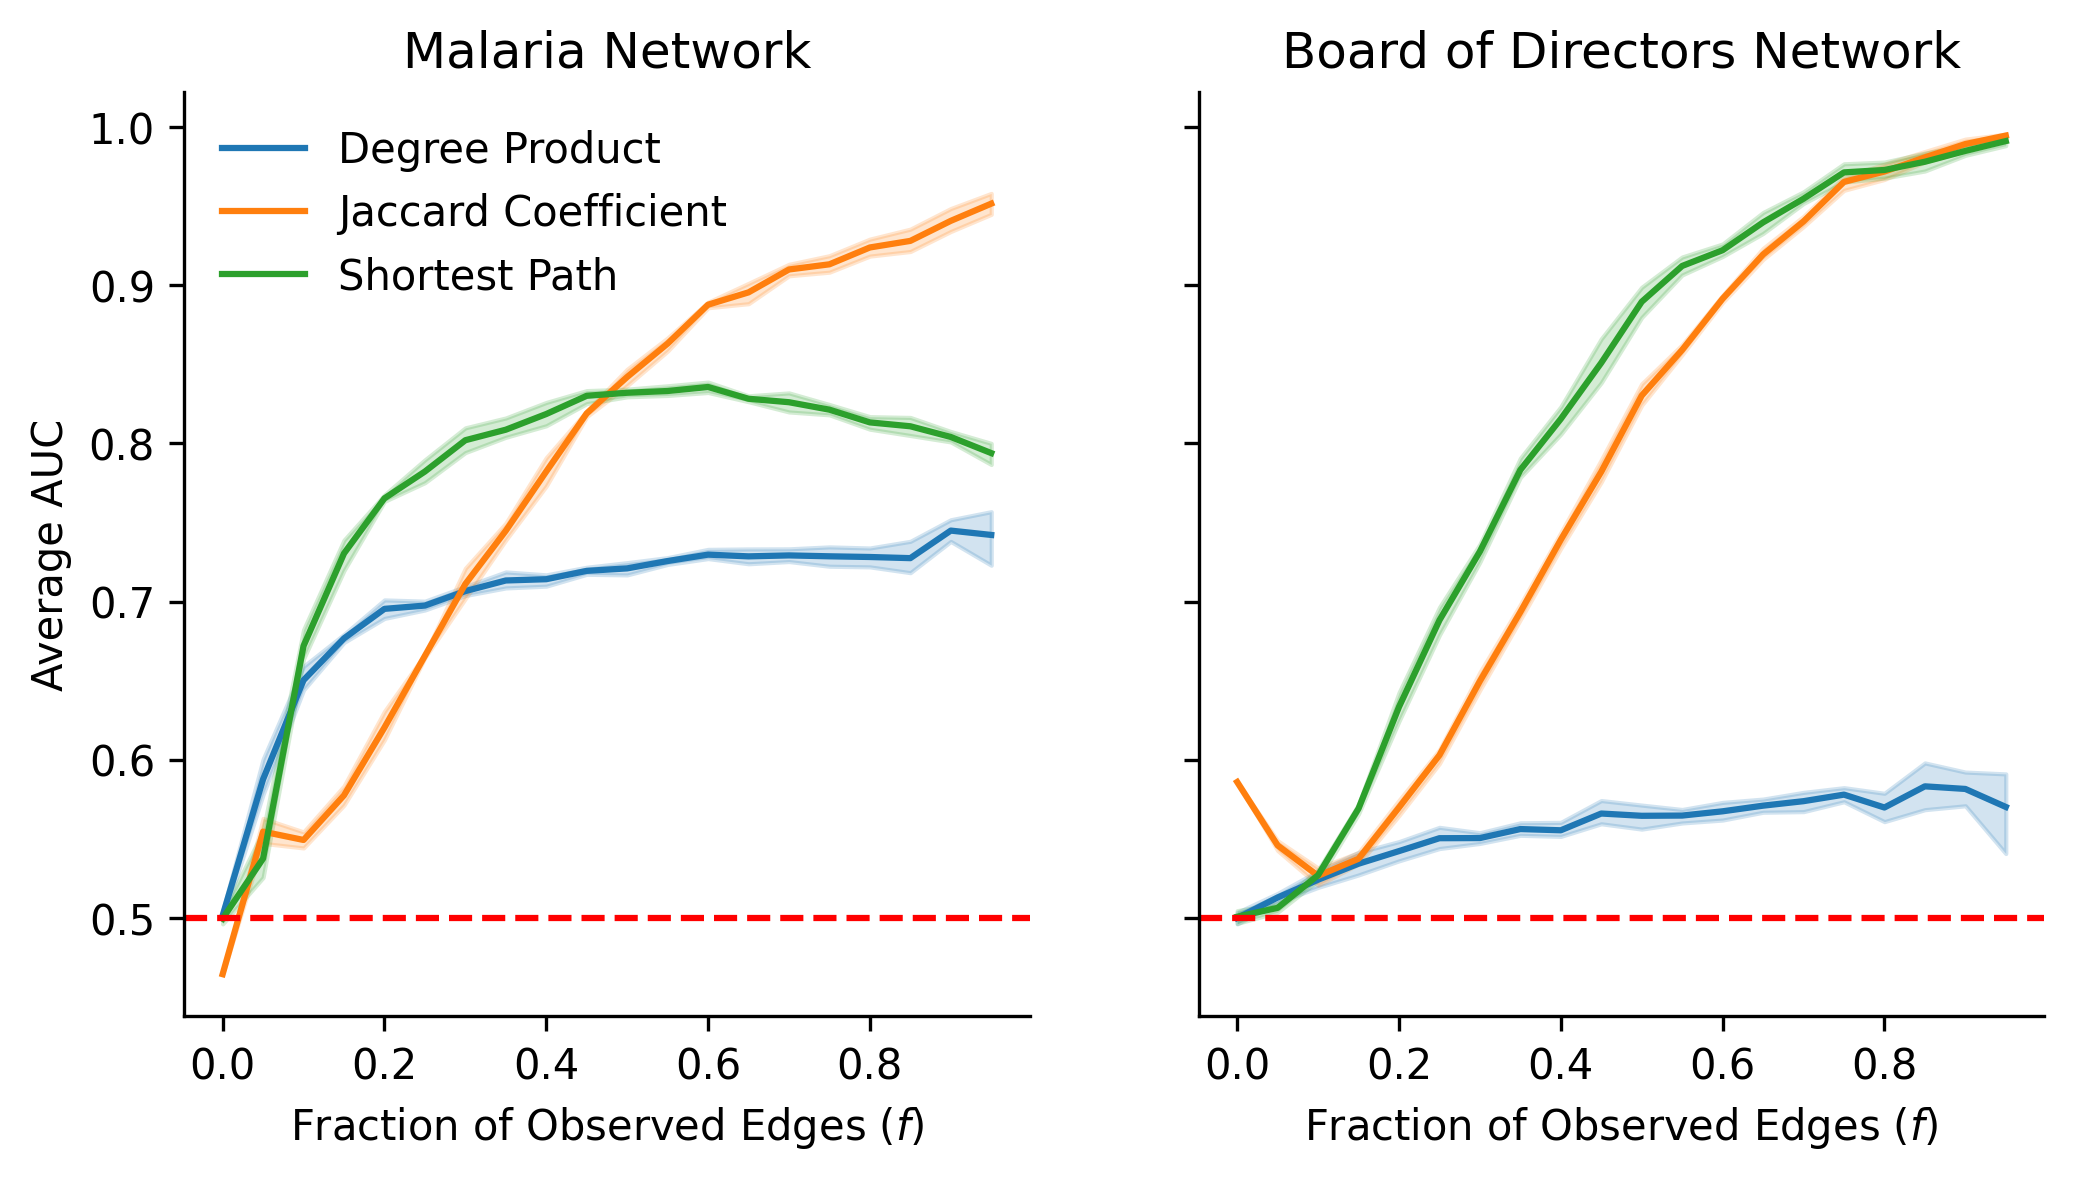

In [510]:
# Plot accuracy curves
fig, ax = plt.subplots(1,2,figsize=(8,4),dpi=300,sharey=True)

sns.lineplot(data=malaria_acc_df,x='f',y='AUC_dp',label='Degree Product',ax=ax[0])
sns.lineplot(data=malaria_acc_df,x='f',y='AUC_jc',label='Jaccard Coefficient',ax=ax[0])
sns.lineplot(data=malaria_acc_df,x='f',y='AUC_sp',label='Shortest Path',ax=ax[0])

ax[0].axhline(0.5,color='red',linestyle='--')

ax[0].set_ylabel('Average AUC')
ax[0].set_xlabel('Fraction of Observed Edges ($f$)')
ax[0].set_title('Malaria Network')
ax[0].legend(frameon=False,loc='upper left')

sns.lineplot(data=board_acc_df,x='f',y='AUC_dp',label='Degree Product',ax=ax[1])
sns.lineplot(data=board_acc_df,x='f',y='AUC_jc',label='Jaccard Coefficient',ax=ax[1])
sns.lineplot(data=board_acc_df,x='f',y='AUC_sp',label='Shortest Path',ax=ax[1])

ax[1].axhline(0.5,color='red',linestyle='--')

ax[1].set_ylabel('Average AUC')
ax[1].set_xlabel('Fraction of Observed Edges ($f$)')
ax[1].set_title('Board of Directors Network')
ax[1].legend().remove()

sns.despine()
plt.show()

In [497]:
f = 0.8
sampled_graph = remove_fraction_edges(malaria_graph, f)
node_pairs = [(a, b) for a in sampled_graph.nodes() for b in sampled_graph.nodes() if a < b]

malaria_scores_f08_df = pd.DataFrame({
    'node_pair': node_pairs,
    'tau': [malaria_graph.has_edge(a, b) for a, b in node_pairs],
	'trainset': [sampled_graph.has_edge(a, b) for a, b in node_pairs],
    'dp': [degree_product((a, b), sampled_graph) for a, b in node_pairs],
    'jc': [jaccard_coefficient((a, b), sampled_graph) for a, b in node_pairs],
    'sp': [shortest_path((a, b), sampled_graph) for a, b in node_pairs]
})

malaria_scores_f08_df, malaria_auc_f08 = auc(malaria_scores_f08_df)


In [498]:
malaria_auc_f08

{'dp': np.float64(0.7301939627082896),
 'jc': np.float64(0.9208149424639414),
 'sp': np.float64(0.8145660443003775)}

In [499]:
malaria_scores_f08_df

,node_pair,tau,trainset,dp,jc,sp,TPR_dp,FPR_dp,TPR_jc,FPR_jc,TPR_sp,FPR_sp
0,"(3, 6)",True,True,96.000001,3.333338e-01,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,"(3, 7)",False,False,248.000000,7.339020e-07,0.250001,0.001866,0.000024,0.003731,0.000000,0.0,0.000048
2,"(3, 8)",False,False,264.000000,3.539816e-07,0.250001,0.001866,0.000048,0.005597,0.000000,0.0,0.000072
3,"(3, 5)",False,False,16.000000,7.830113e-07,0.250001,0.001866,0.000072,0.007463,0.000000,0.0,0.000096
4,"(3, 4)",False,False,96.000000,1.764715e-01,0.500000,0.001866,0.000096,0.007463,0.000024,0.0,0.000120
...,...,...,...,...,...,...,...,...,...,...,...,...
44248,"(307, 99)",False,False,525.000000,2.222300e-02,0.500000,NaN,NaN,NaN,NaN,NaN,NaN
44249,"(307, 40)",False,False,84.000000,8.695672e-02,0.500001,NaN,NaN,NaN,NaN,NaN,NaN
44250,"(307, 72)",False,False,63.000000,6.604741e-07,0.333334,NaN,NaN,NaN,NaN,NaN,NaN
44251,"(307, 83)",False,False,63.000000,3.496688e-07,0.333334,NaN,NaN,NaN,NaN,NaN,NaN


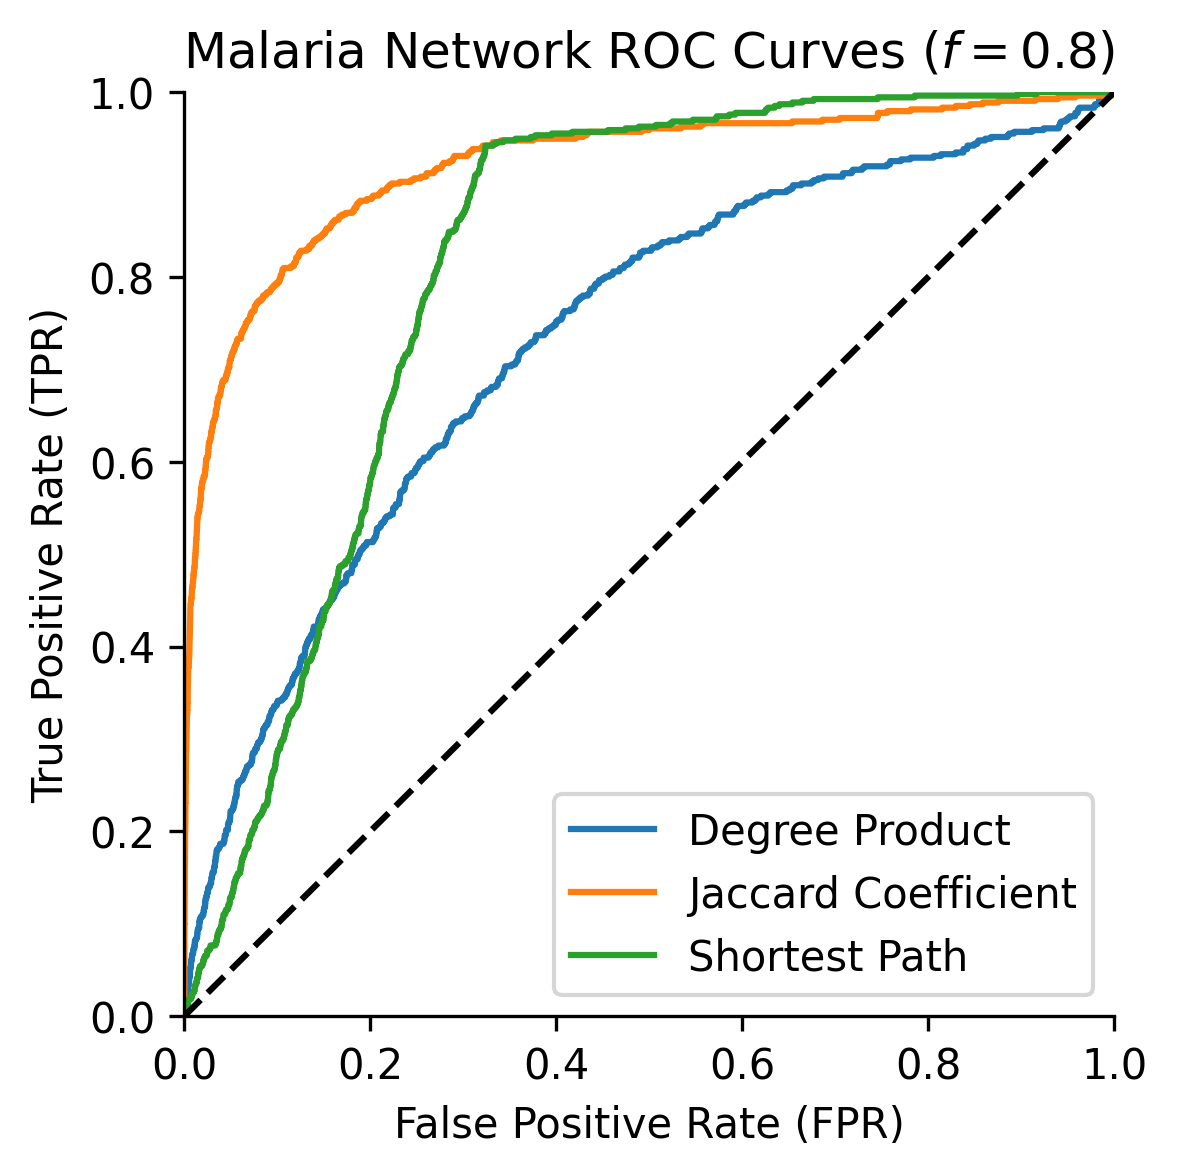

In [500]:
# Plot AUC curves
fig, ax = plt.subplots(1,1,figsize=(4,4),dpi=300)

sns.lineplot(data=malaria_scores_f08_df,x='FPR_dp',y='TPR_dp',label='Degree Product',ax=ax)
sns.lineplot(data=malaria_scores_f08_df,x='FPR_jc',y='TPR_jc',label='Jaccard Coefficient',ax=ax)
sns.lineplot(data=malaria_scores_f08_df,x='FPR_sp',y='TPR_sp',label='Shortest Path',ax=ax)
ax.set_title('Malaria Network ROC Curves ($f=0.8$)')
ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR)')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.plot([0,1],[0,1],color='black',linestyle='--')

sns.despine()
plt.show()

In the Malaria network, the degree product takes an early lead in AUC at low $f$ values. However, it significantly underperforms as $f$ gets large. This is likely because the degree product is relatively effective at "easy" predictions, where the most high-degree nodes are likely connected to high-degree nodes as well. It becomes much less effective as the degree products go down since the nodes become lower-degree and the statistical trend the predictor relies on diminishes.

Since the Malaria network has the best performance with the Jaccard coefficient, that network likely forms tight clusters/communities. The board of directors network similarly has good performance with Jaccard, but also with the shortest path algorithm.

Overall, the ROC curves show that the Jaccard coefficient is an excellent predictor of node labels especially at high values. The degree product is moderately good at predicting labels but frequently makes incorrect predictions even at values that should provide confident predictions. Finally, the shortest path algorithm performs decently well for shorter paths until it plateaus at very short paths, where the information provided by local connectivity becomes more misleading than useful.